Code to recreate the NNapex Peacock code from Matlab
This performs performs poly queries using the NNapex using the perfect point method.
TODO Rename this file!

In [1]:
import sys
!{sys.executable} -m pip install torch torchvision scipy matplotlib | grep -v 'already satisfied'

In [2]:
def clearvars():    
    for el in sorted(globals()):
        if '__' not in el:
                print(f'deleted: {el}')
                del el

In [3]:
# clearvars()

In [4]:
import pathlib
from simcoder.similarity import load_mf_encodings

allData = load_mf_encodings(pathlib.Path("/Volumes/Data/mf_resnet50/")) # load resnet 50 encodings

In [5]:

from scipy.io import loadmat
import numpy as np

def load_mf_softmax():
    basepath = pathlib.Path("/Volumes/Data/mf_softmax/")

    paths = basepath.glob("*.mat")
    paths = sorted(paths, key=lambda p: int(p.stem))
    encodings = [loadmat(p)["probVecs"] for p in paths]
    encodings = np.concatenate(encodings)
    return encodings



In [6]:
smData = load_mf_softmax()

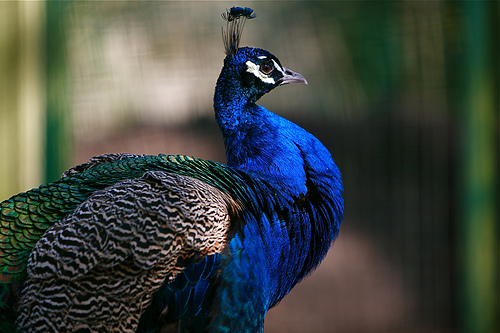

In [7]:
# Get the peacock at index 

from simcoder.similarity import get_mf_image

q0 = 101102 # a peacock

get_mf_image(q0)

In [8]:
from simcoder.similarity import euclid as euclid

def getDists(query_index,allData):
    '''Return the distances from the query to allData'''
    '''Returns an array same dimension as allData of scalars'''
    mf_query_data = allData[query_index]
    distances = euclid(mf_query_data, allData)
    return distances

In [9]:
from matplotlib import pyplot as plt

def imShow( image ):
    # plt.title(Image title")
    #plt.xlabel("X pixel scaling")
    # plt.ylabel("Y pixels scaling")

    fig = plt.figure(figsize = (1,1)) # in inches!
    plt.axis('off')
    plt.imshow(image) # figsize=(640/80,640/80), dpi=80)
    plt.show()

In [10]:
dists = getDists(q0,allData)
closest_indices = np.argsort(dists) # the closest images to the query

poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query

best_100_for_single = closest_indices[0:100]

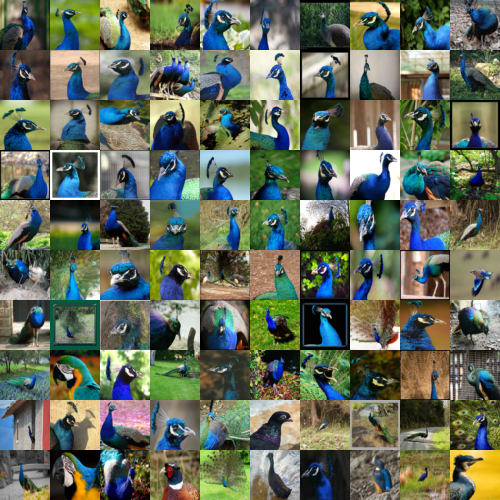

In [11]:
# These are the best images best on lowest average distance from the queries

from simcoder.similarity import make_mf_image_grid

make_mf_image_grid(best_100_for_single,10,10,50,50)

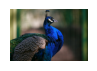

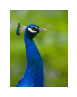

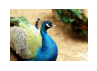

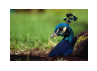

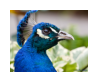

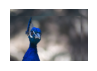

In [12]:
dists = getDists(q0,allData)
closest_indices = np.argsort(dists) # the closest images to the query

poly_query_indexes = closest_indices[0:6] # These are the indices we will use for the poly query

for i in range(0,6): # 0 is the original image
    imShow(get_mf_image(poly_query_indexes[i]))

poly_query_data = allData[poly_query_indexes]

In [13]:
# Fetch the data and whole-set distances for the extra query objects
# fc6_poly_queries is the FC6 data for the queries we have chosen - not needed
# poly_query_distances is the distances from the queries to the all data 1000000,6

num_poly_queries = len(poly_query_indexes)

print(num_poly_queries)
print(poly_query_data.shape)

poly_query_distances = np.zeros((num_poly_queries,1000*1000))
for i in range(num_poly_queries):
    poly_query_distances[i] = getDists(poly_query_indexes[i],allData) 

6
(6, 1000)


In [14]:
# Here we will use some estimate of the nn distance to each query to construct a
# new point in the nSimplex projection space formed by the poly query objects

nnToUse = 10

ten_nn_dists = np.zeros(num_poly_queries);

for i in range(num_poly_queries):
    sortedDists = np.sort(poly_query_distances[i]);
    ten_nn_dists[i] = sortedDists[nnToUse];


In [29]:
import math 

def euclid_scalar(p1: np.array, p2: np.array):
    distances = math.sqrt(np.sum((p1 - p2) ** 2))
    return distances

from simcoder.nsimplex import NSimplex

def fromSimplexPoint(poly_query_distances : np.array, inter_pivot_distances : np.array, nn_dists:  np.array) -> np.array:
    '''poly_query_data is the set of reference points with which to build the simplex'''
    '''inter_pivot_distances are the inter-pivot distances with which to build the base simplex'''
    '''nn_dists is a column vec of distances, each abit more than the nn distance from each ref to the rest of the data set'''
    '''ie the "perfect" intersection to the rest of the set'''
    '''returns a np.array of distances between the perfect point and the rest of the data set'''

    nsimp = NSimplex()
    nsimp.build_base(inter_pivot_distances,False)

    # second param a (B,N)-shaped array containing distances to the N pivots for B objects.
    perfPoint = nsimp._get_apex(nsimp._base,nn_dists)    # was projectWithDistances in matlab

    for i in range(1000 * 1000):
        distvec = poly_query_distances[:,i];                      # a row vec of distances
        pr = nsimp._get_apex(nsimp._base,np.transpose(distvec));
        dists[i] = euclid_scalar(pr,perfPoint)

    return dists


In [16]:
# from Italian documentation: README.md line 25
from scipy.spatial.distance import pdist, squareform

inter_pivot_distances = squareform(pdist(poly_query_data, metric=euclid_scalar)) # pivot-pivot distance matrix with shape (n_pivots, n_pivots)

In [19]:
xx = NSimplex()
xx.build_base(poly_query_distances,False)
print(xx._base.shape)
print(xx._base)
print(inter_pivot_distances.shape)
print(inter_pivot_distances)

(6, 5)
[[  0.           0.           0.           0.           0.        ]
 [ 98.65367889   0.           0.           0.           0.        ]
 [ 39.22830695  92.05004196   0.           0.           0.        ]
 [ 36.17277752  -6.60279593  95.60034309   0.           0.        ]
 [ 37.59948343  -6.64461791  36.44596512  93.99282929   0.        ]
 [ 39.17988873 -11.22089339  33.99878126  19.72742924  85.17730522]]
(6, 6)
[[ 0.         50.7874876  50.92856277 53.38099626 53.92772217 54.23164472]
 [50.7874876   0.         44.98976392 51.10771025 49.90157549 47.76080999]
 [50.92856277 44.98976392  0.         48.40539258 52.89213901 48.43856854]
 [53.38099626 51.10771025 48.40539258  0.         49.4735567  53.00234001]
 [53.92772217 49.90157549 52.89213901 49.4735567   0.         46.92612837]
 [54.23164472 47.76080999 48.43856854 53.00234001 46.92612837  0.        ]]


In [30]:
distsToPerf = fromSimplexPoint(poly_query_distances,inter_pivot_distances,ten_nn_dists);  # was multipled by 1.1 in some versions!

/Users/al/repos/github/simcoder-pytorch/simcoder/nsimplex.py:41: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(y_n ** 2 - w ** 2)
/Users/al/repos/github/simcoder-pytorch/simcoder/nsimplex.py:46: UserWarning: one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot 1 is [0.00032982])
  warnings.warn(f"one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot {k} is {diff})")
/Users/al/repos/github/simcoder-pytorch/simcoder/nsimplex.py:46: UserWarning: one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot 2 is [-0.00045029])
  warnings.warn(f"one or more points does not satisfies the n-point property, or the max dim was reached (diff for vertex-pivot {k} is {diff})")
/Users/al/repos/github/simcoder-pytorch/simcoder/nsimplex.py:46: UserWarning: one or more points does not satisfies the n-point property, or the ma

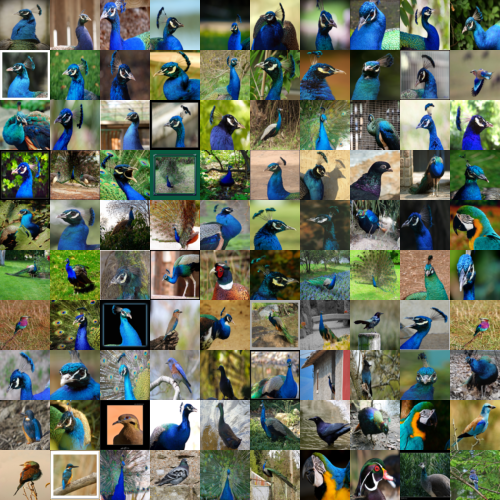

In [31]:
closest_indices = np.argsort(distsToPerf) # the closest images to the perfect point

best_100_for_perfect_point = closest_indices[0:100]

make_mf_image_grid(best_100_for_perfect_point,10,10,50,50)

In [32]:
# Load the sotmax encodings of the data

softmax_encodings = load_mf_softmax()


In [34]:
# Now want to report results the total count in the category

from simcoder.count_cats import countNumberinCatGTThresh 
from simcoder.count_cats import countNumberInResultsInCat

peacock_category = 84

encodings_for_best_100_single = softmax_encodings[best_100_for_single] # the alexnet encodings for the best 100 average singlequery images
single_peacock_totals = encodings_for_best_100_single[:,peacock_category]
print("Total peacock sum for single query best 100: ", np.sum(single_peacock_totals))


encodings_for_best_100_average = softmax_encodings[best_100_for_perfect_point] # the alexnet encodings for the best 100 polyquery images
average_peacock_totals = encodings_for_best_100_average[:,peacock_category]
print("Total peacock sum for poly query best 100: ", np.sum(average_peacock_totals))

res = countNumberInResultsInCat(peacock_category,0.9,best_100_for_single,softmax_encodings)
print("Total with thresh better than 0.9 single query : ", res)

res = countNumberInResultsInCat(peacock_category,0.9,best_100_for_perfect_point,softmax_encodings)
print("Total with thresh better than 0.9 poly query : ", res)

Total peacock sum for single query best 100:  84.09667855453304
Total peacock sum for poly query best 100:  72.74694230449238
Total with thresh better than 0.9 single query :  77
Total with thresh better than 0.9 poly query :  67


# This is the Matlab code

allData = load_mf_resnet50(false,0);
smData = load_mf_softmax(1000);


net = alexnet;
alexNetCats = net.Layers(25,1).Classes;
q0s = findHighCatValues(smData);
choose a query and get the nns


q0 = q0s(16) - 1 %peacock


imshow(getFullImage(q0));



Find some images that are similar to the q0 query
p0 = allData(q0 + 1,:);
p0Dists = getDistsMemo(allData,q0 + 1);
indp0 = showSortedImagesByDistance(p0Dists);



[s,vals] = getSoftmaxSum(q0+1, indp0, smData);
sum(vals > 0.9)

Find the best  pics for polyquery by examining softmax layers

bestCats = getBestCats(q0 + 1, indp0, 5, smData);
poly_query_indexes = indp0(bestCats);

imshow(getFullImage(poly_query_indexes(1) - 1));
imshow(getFullImage(poly_query_indexes(2) - 1));
imshow(getFullImage(poly_query_indexes(3) - 1));
imshow(getFullImage(poly_query_indexes(4) - 1));
imshow(getFullImage(poly_query_indexes(5) - 1));
These indices are all in the thumbnail space and the indices are one bigger then the full image indices.


fetch the data and whole-set distances for the extra query objects
pN is the FC6 data for the queries we have chosen (qs).
pDists is the distances from the queries to the all data
noOfMatches = size(poly_query_indexes,1);

pN = zeros(noOfMatches,1000);
pDists = zeros(1000*1000,noOfMatches);

for i = 1 : noOfMatches
    pN(i,:) = allData(poly_query_indexes(i),:);
    pDists(:,i) = getDistsMemo(allData,poly_query_indexes(i));
end

Down to here, we have built up:
pN, the data for a set of extra queries which are similar to the first two
p0dists, p1dists, and pDists: the unordered distances from these values to the whole data set

The poly-query comprises the whole set of images, so let's combine them first:

polyQueryData = [pN];
polyQueryDists = [pDists];
noOfPolyQueries = size(polyQueryDists,2);

Here we will use some estimate of the nn distance to each query to construct a new point in the nSimplex projection space formed by the poly query objects

nnToUse = 10;

tenNNdists = zeros(noOfPolyQueries,1);

for i = 1 : noOfPolyQueries
    sortedDists = sort(polyQueryDists(:,i));
    tenNNdists(i) = sortedDists(nnToUse);
end

distsToPerf = fromSimplexPoint(polyQueryData,polyQueryDists,tenNNdists .* 1.1);

***** HERE

ord = showSortedImagesByDistance(distsToPerf);

[s,vals] = getSoftmaxSum(q0+1, ord, smData);
sum(vals > 0.9)



function hm = harmonicMean(val1,val2)
hm = 2 ./ (1 / val1 + 1 / val2);
end

function [res,vals] = getSoftmaxSum(initialId, nnIds, smData )
%ord is the higest to lowest of the query dimensions by softmax value
[~,ord] = sort(smData(initialId,:),"descend");
%nnData is the softmax data of the nearest neighbours
nnData = smData(nnIds,:);
category = ord(1);
vals = nnData(:,category);
res = sum(vals);
end

function res = getBestCats(initialId, nnIds, n, smData )
%ord is the higest to lowest of the query dimensions by softmax value
[~,ord] = sort(smData(initialId,:),"descend");
%nnData is the softmax data of the nearest neighbours
nnData = smData(nnIds,:);
category = ord(1);
nnCategories = nnData(:,category);
[~,ord] = sort(nnCategories,"descend");
res = ord(1:n);
end

function res = findHighCatValues(smData)
%smData is an n x 1000 array of softmax values
%return the indices in order of the highest value in each row

maxes = max(smData,[],2);
[~,ord] = sort(maxes,"descend");
res = ord(1:20);

end




